In [12]:
import xarray as xr
import pandas as pd
import rasterio
from rasterio.transform import from_origin
import numpy as np
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
from rasterio.plot import show

In [2]:
file = r'/scratch/project_2000908/nousu/mNFI_to_NEP/MASKS/NF_SF_region_mask.nc'
orig_data = xr.open_dataset(file)

# Define the mapping: 'NF' -> 0.0, 'SF' -> 1.0, 'NA' -> np.nan
mapping = {'NF': 0.0, 'SF': 1.0, 'NA': np.nan}

# Apply the mapping to the 'region' variable
region_numeric = xr.apply_ufunc(
    lambda x: np.vectorize(mapping.get)(x),
    orig_data['region'],
    dask='allowed',
    output_dtypes=[float]
)

# Create a new dataset including the numeric version
data = xr.Dataset({'region': region_numeric})

In [4]:
output_file_kkj = f'/scratch/project_2000908/nousu/mNFI_to_NEP/MASKS/khk_mask_kkj.tif'
output_file_tm35fin = f'/scratch/project_2000908/nousu/mNFI_to_NEP/MASKS/khk_mask_tm35.tif'

variable = 'region'
datas = data[variable]
lat = data['lat'].values
lon = data['lon'].values
values = datas.values
values = np.flipud(values)  # flip vertically

nodata_value = -9999
values[np.isnan(values)] = nodata_value

res_y = np.abs(lat[1] - lat[0])
res_x = np.abs(lon[1] - lon[0])

# Original transform in KKJ
transform_kkj = from_origin(west=lon.min() - res_x / 2,
                            north=lat.max() + res_y / 2,
                            xsize=res_x,
                            ysize=res_y)

# Step 1: Save in original KKJ CRS (EPSG:2393 or your actual KKJ zone)
with rasterio.open(
    output_file_kkj,
    "w",
    driver="GTiff",
    height=values.shape[0],
    width=values.shape[1],
    count=1,
    dtype=values.dtype,
    crs="EPSG:2393",  # KKJ / Finland zone 3
    transform=transform_kkj,
    nodata=nodata_value
) as dst:
    dst.write(values, 1)

# Step 2: Reproject to EPSG:3067
with rasterio.open(output_file_kkj) as src:
    transform_3067, width, height = calculate_default_transform(
        src.crs, "EPSG:3067", src.width, src.height, *src.bounds)

    kwargs = src.meta.copy()
    kwargs.update({
        "crs": "EPSG:3067",
        "transform": transform_3067,
        "width": width,
        "height": height
    })

    with rasterio.open(output_file_tm35fin, "w", **kwargs) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform_3067,
            dst_crs="EPSG:3067",
            resampling=Resampling.nearest,
            src_nodata=nodata_value,
            dst_nodata=nodata_value
        )

print(f"Saved {variable} reference grid to EPSG:3067")

Saved region reference grid to EPSG:3067


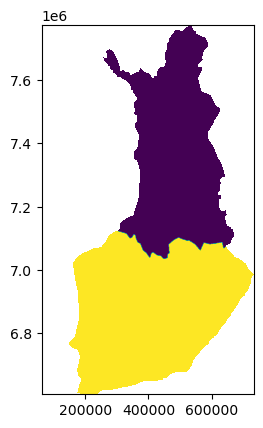

In [13]:
with rasterio.open(output_file_tm35fin) as src:
    data = src.read(1)
    meta = src.meta
    show(src)